In [1]:
import os
os.environ['SPS_HOME'] = '/Users/annalena/Documents/GitHub/fsps'

# Compare different stellar models

## Step 1: Configuration

Below is an example configuration for running the pipeline with NIHAO data. Replace path and halo_path with the paths to your NIHAO snapshot and halo files. This configuration supports quick testing by using only a subset of the data (1000 particles).


In [2]:
#NBVAL_SKIP
config = {
    "pipeline": {"name": "calc_gradient"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 12,
        "reuse": True,
        },

        "subset": {
            "use_subset": True,
            "subset_size": 10000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-12.hdf5",
        },
    
    },
    "output_path": "output",
    "output_modified": False,

    "telescope": {
        "name": "MUSE",
        "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
        "lsf": {"sigma": 0.5},
        "noise": {"signal_to_noise": 100, "noise_distribution": "normal"},
    },
    "cosmology": {"name": "PLANCK15"},
    "galaxy": {
        "dist_z": 0.2,
        "rotation": {"type": "face-on"},
    },
    "ssp": {
        "template": {"name": "BruzualCharlot2003"},
    },
}

## Step 2: Pipeline YAML

To run the RUBIX pipeline, you need a YAML file (stored in rubix/config/pipeline_config.yml) that defines which functions are used during the execution of the pipeline.

## Step 3: Run the Pipeline

Now, simply execute the pipeline with the following code.


In [3]:
#NBVAL_SKIP
import jax.numpy as jnp
from rubix.core.pipeline import RubixPipeline
pipe = RubixPipeline(config)

rubixdata_input = pipe.run()

rubixdata_input.stars.age = jnp.full_like(rubixdata_input.stars.age, 10)
rubixdata_input.stars.metallicity = jnp.full_like(rubixdata_input.stars.metallicity, 0.008)

2025-02-04 15:45:05,713 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-02-04 15:45:05,713 - rubix - INFO - Rubix version: 0.0.post366+g4480c14
/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-02-04 15:45:06,002 - rubix - INFO - Getting rubix data...
2025-02-04 15:45:06,003 - rubix - INFO - Loading data from IllustrisAPI
2025-02-04 15:45:06,003 - rubix - INFO - Reusing existing file galaxy-id-12.hdf5. If you want to download the data again, set reuse=False.
2025-02-04 15:45:06,023 - rubix - INFO - Loading data into input handler
2025-02-04 15:45:06,023 - rubix - DEBUG - Loading data from Illustris file..
2025-02-04 15:45:06,024 - rubix - DEBUG - Checking if the fields are present in the file...
2025-02-04 15:45:06,024 - 

In [4]:
#NBVAL_SKIP
from rubix.core.pipeline_gradient import RubixPipeline
pipe = RubixPipeline(config)

rubixdata = pipe.run(rubixdata_input)

rubixdata_bruzual = rubixdata

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-02-04 15:45:14,189 - rubix - INFO - Setting up the pipeline...
2025-02-04 15:45:14,190 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'sc

In [5]:
config["ssp"]["template"]["name"] = "FSPS"

pipe = RubixPipeline(config)

rubixdata = pipe.run(rubixdata_input)
rubixdata_fsps = rubixdata

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-02-04 15:45:16,367 - rubix - INFO - Setting up the pipeline...
2025-02-04 15:45:16,367 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'sc

In [6]:
config["ssp"]["template"]["name"] = "Mastar_CB19_SLOG_1_5"

pipe = RubixPipeline(config)

rubixdata = pipe.run(rubixdata_input)
rubixdata_mastar = rubixdata

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-02-04 16:58:21,749 - rubix - INFO - Setting up the pipeline...
2025-02-04 16:58:21,749 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': 'calculate_spectra', 'depends_on': 'reshape_data', 'args': [], 'kwargs': {}}, 'scale_spectrum_by_mass': {'name': 'scale_spectrum_by_mass', 'depends_on': 'calculate_spectra', 'args': [], 'kwargs': {}}, 'doppler_shift_and_resampling': {'name': 'doppler_shift_and_resampling', 'depends_on': 'sc

## Step 4: Visualize the Mock Data
### Plot a Spectrum for a Single Spaxel

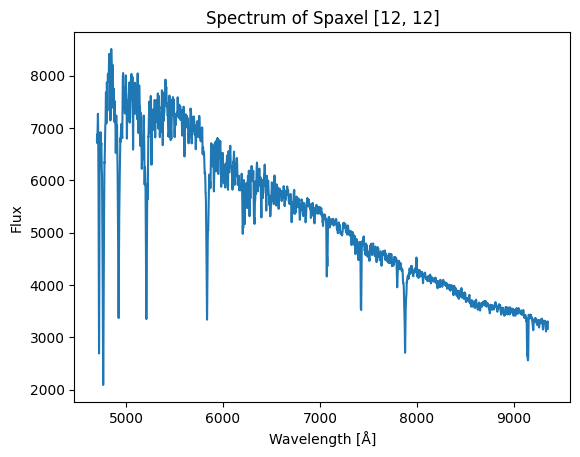

In [7]:
#NBVAL_SKIP
import jax.numpy as jnp
import matplotlib.pyplot as plt

wave = pipe.telescope.wave_seq
spectra = rubixdata_mastar.stars.datacube

plt.plot(wave, spectra[12, 12, :])
plt.title("Spectrum of Spaxel [12, 12]")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.show()

### Create a Spatial Image from the Data Cube

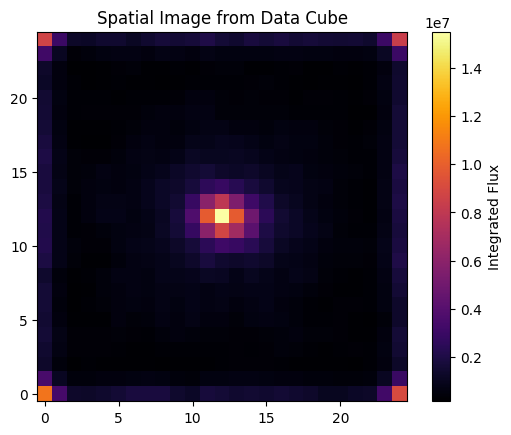

In [8]:
#NBVAL_SKIP
from matplotlib.colors import LogNorm

visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))

visible_spectra = spectra[:, :, visible_indices[0]]
image = jnp.sum(visible_spectra, axis=2)

plt.imshow(image, origin="lower", cmap="inferno")
plt.colorbar(label="Integrated Flux")
plt.title("Spatial Image from Data Cube")
plt.show()

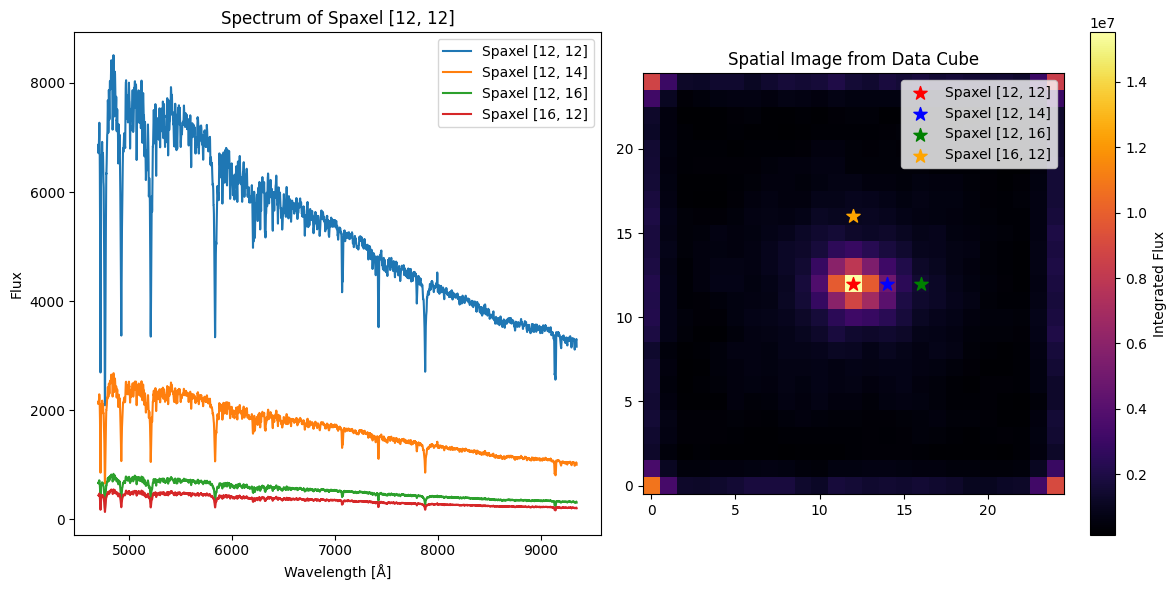

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Assuming wave and spectra are already defined
wave = pipe.telescope.wave_seq
spectra = rubixdata_mastar.stars.datacube

# Define the spaxel index to highlight
spaxel_x, spaxel_y = 12, 12
spaxel_x2, spaxel_y2 = 12, 14
spaxel_x3, spaxel_y3 = 12, 16
spaxel_x4, spaxel_y4 = 16, 12

# Prepare the visible range data
visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))
visible_spectra = spectra[:, :, visible_indices[0]]
image = jnp.sum(visible_spectra, axis=2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the spectrum on the left
axes[0].plot(wave, spectra[spaxel_x, spaxel_y, :], label=f"Spaxel [{spaxel_x}, {spaxel_y}]")
axes[0].plot(wave, spectra[spaxel_x2, spaxel_y2, :], label=f"Spaxel [{spaxel_x2}, {spaxel_y2}]")
axes[0].plot(wave, spectra[spaxel_x3, spaxel_y3, :], label=f"Spaxel [{spaxel_x3}, {spaxel_y3}]")
axes[0].plot(wave, spectra[spaxel_x4, spaxel_y4, :], label=f"Spaxel [{spaxel_x4}, {spaxel_y4}]")
axes[0].set_title("Spectrum of Spaxel [12, 12]")
axes[0].set_xlabel("Wavelength [Å]")
axes[0].set_ylabel("Flux")
axes[0].legend()

# Plot the image on the right
im = axes[1].imshow(image, origin="lower", cmap="inferno")
axes[1].scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100, label="Spaxel [12, 12]")  # Mark the spaxel
axes[1].scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100, label="Spaxel [12, 14]")  # Mark the spaxel
axes[1].scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100, label="Spaxel [12, 16]")  # Mark the spaxel
axes[1].scatter(spaxel_y4, spaxel_x4, color="orange", marker="*", s=100, label="Spaxel [16, 12]")  # Mark the spaxel
axes[1].set_title("Spatial Image from Data Cube")
axes[1].legend()
cbar = fig.colorbar(im, ax=axes[1], orientation="vertical", label="Integrated Flux")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

2099728.2 2027163.2 19492942.0


/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_30909/2227091506.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


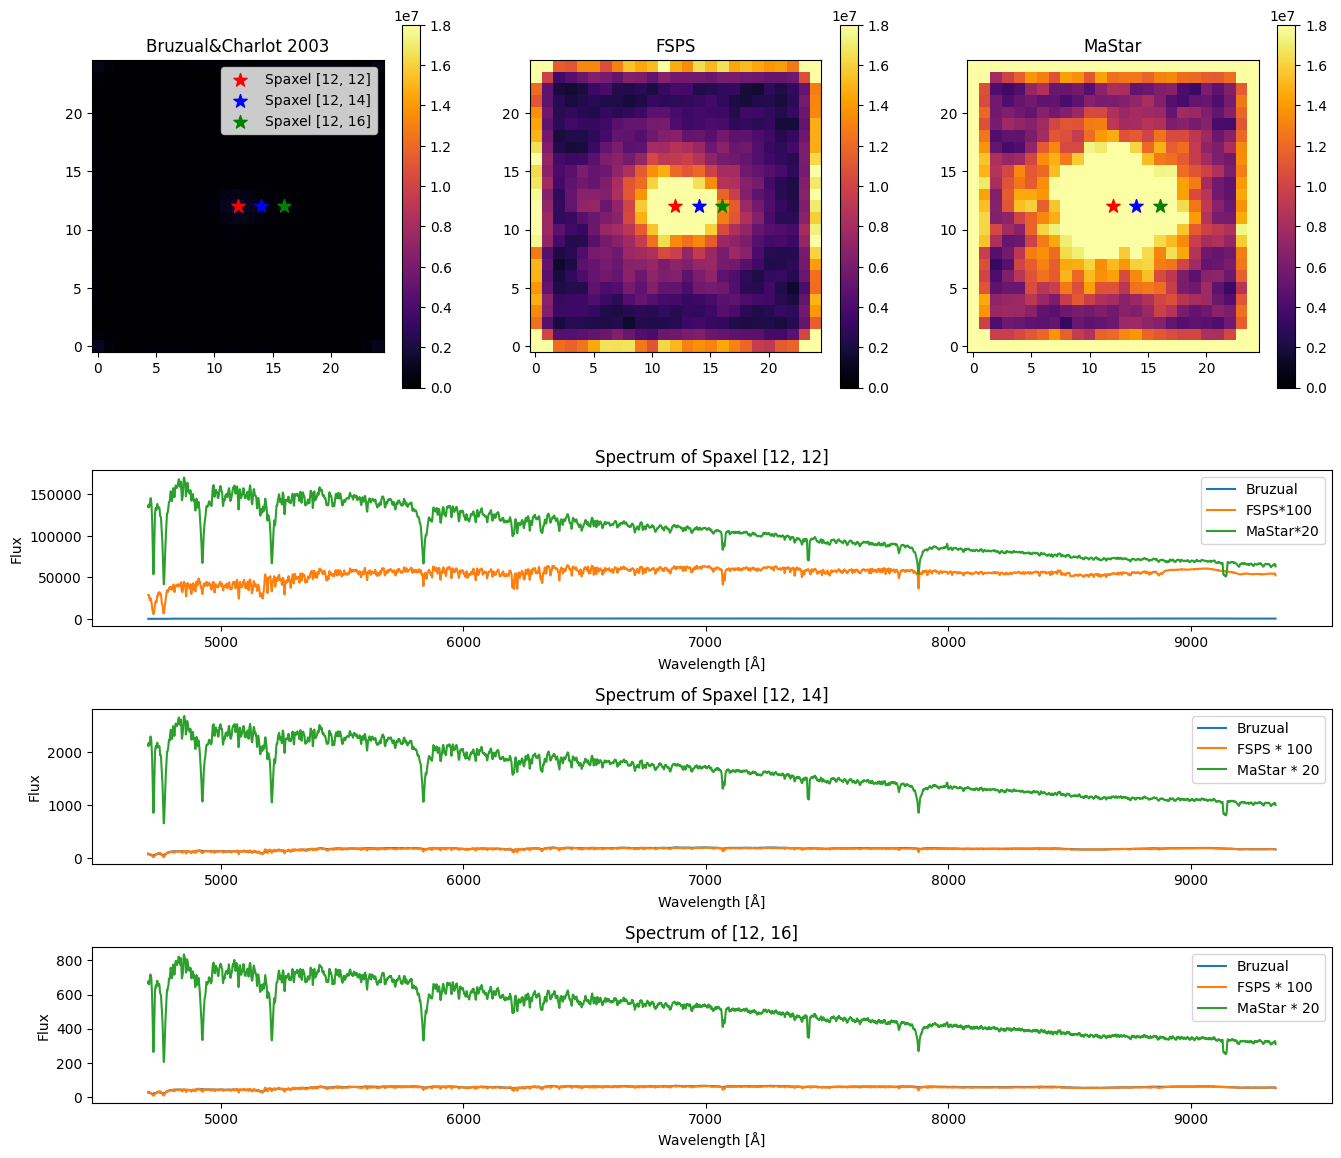

In [10]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

# Assuming wave, spectra, image, image2, and image3 are defined
wave = pipe.telescope.wave_seq
spectra1 = rubixdata_bruzual.stars.datacube
spectra2 = rubixdata_fsps.stars.datacube
spectra3 = rubixdata_mastar.stars.datacube

# Spaxel to highlight
spaxel_x, spaxel_y = 12, 12
spaxel_x2, spaxel_y2 = 12, 14
spaxel_x3, spaxel_y3 = 12, 16

# Example images (replace with your data)
visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))
visible_spectra1 = spectra1[:, :, visible_indices[0]]
visible_spectra2 = spectra2[:, :, visible_indices[0]]
visible_spectra3 = spectra3[:, :, visible_indices[0]]
image1 = jnp.sum(visible_spectra1, axis=2)  # Bruzual image
image2 = jnp.sum(visible_spectra2, axis=2)  # FSPS image
image3 = jnp.sum(visible_spectra3, axis=2)  # MaStar image

vmin = 0

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(4, 3, height_ratios=[0.7, 0.3, 0.3, 0.3], hspace=0.4)

sum1 = jnp.sum(spectra1[spaxel_x, spaxel_y, :])
sum2 = jnp.sum(spectra2[spaxel_x, spaxel_y, :])
sum3 = jnp.sum(spectra3[spaxel_x, spaxel_y, :])
print(sum1, sum2, sum3)

# First row: images
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(image1, origin="lower", cmap="inferno", vmin=vmin, vmax=1.8e7)#, norm=LogNorm())
ax1.scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100, label="Spaxel [12, 12]")
ax1.scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100, label="Spaxel [12, 14]")
ax1.scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100, label="Spaxel [12, 16]")
ax1.set_title("Bruzual&Charlot 2003")
ax1.legend()
fig.colorbar(im1, ax=ax1, orientation="vertical")

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(image2 * 100, origin="lower", cmap="inferno", vmin=vmin, vmax=1.8e7)#, norm=LogNorm())
ax2.scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100)
ax2.scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100)
ax2.scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100)
ax2.set_title("FSPS")
fig.colorbar(im2, ax=ax2, orientation="vertical")

ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(image3 * 20, origin="lower", cmap="inferno", vmin=vmin, vmax=1.8e7)#, norm=LogNorm())
ax3.scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100)
ax3.scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100)
ax3.scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100)
ax3.set_title("MaStar")
fig.colorbar(im3, ax=ax3, orientation="vertical")

# Second row: spectrum
ax4 = fig.add_subplot(gs[1, :])  # Full-width spectrum
ax4.plot(wave, spectra1[spaxel_x, spaxel_y, :], label=f"Bruzual")
ax4.plot(wave, spectra2[spaxel_x, spaxel_y, :]*100, label=f"FSPS*100")
ax4.plot(wave, spectra3[spaxel_x, spaxel_y, :]*20, label=f"MaStar*20")
#ax4.plot(wave, spectra2[spaxel_x, spaxel_y, :], label=f"Spaxel [{spaxel_x}, {spaxel_y}], FSPS")
#ax4.plot(wave, spectra3[spaxel_x, spaxel_y, :], label=f"Spaxel [{spaxel_x}, {spaxel_y}], MaStar")
ax4.set_title(f"Spectrum of Spaxel [{spaxel_x}, {spaxel_y}]")
ax4.set_xlabel("Wavelength [Å]")
ax4.set_ylabel("Flux")
#ax4.set_yscale("log")
ax4.legend()

ax5 = fig.add_subplot(gs[2, :])  # Full-width spectrum
ax5.plot(wave, spectra1[spaxel_x2, spaxel_y2, :], label=f"Bruzual")
ax5.plot(wave, spectra2[spaxel_x2, spaxel_y2, :], label=f"FSPS * 100")
ax5.plot(wave, spectra3[spaxel_x2, spaxel_y2, :], label=f"MaStar * 20")
ax5.set_title(f"Spectrum of Spaxel [{spaxel_x2}, {spaxel_y2}]")
ax5.set_xlabel("Wavelength [Å]")
ax5.set_ylabel("Flux")
#ax4.set_yscale("log")
ax5.legend()

ax6 = fig.add_subplot(gs[3, :])  # Full-width spectrum
ax6.plot(wave, spectra1[spaxel_x3, spaxel_y3, :], label=f"Bruzual")
ax6.plot(wave, spectra2[spaxel_x3, spaxel_y3, :], label=f"FSPS * 100")
ax6.plot(wave, spectra3[spaxel_x3, spaxel_y3, :], label=f"MaStar * 20")
ax6.set_title(f"Spectrum of [{spaxel_x3}, {spaxel_y3}]")
ax6.set_xlabel("Wavelength [Å]")
ax6.set_ylabel("Flux")
#ax4.set_yscale("log")
ax6.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

2099728.2 2027163.2 19492942.0


/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_30909/3035852599.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


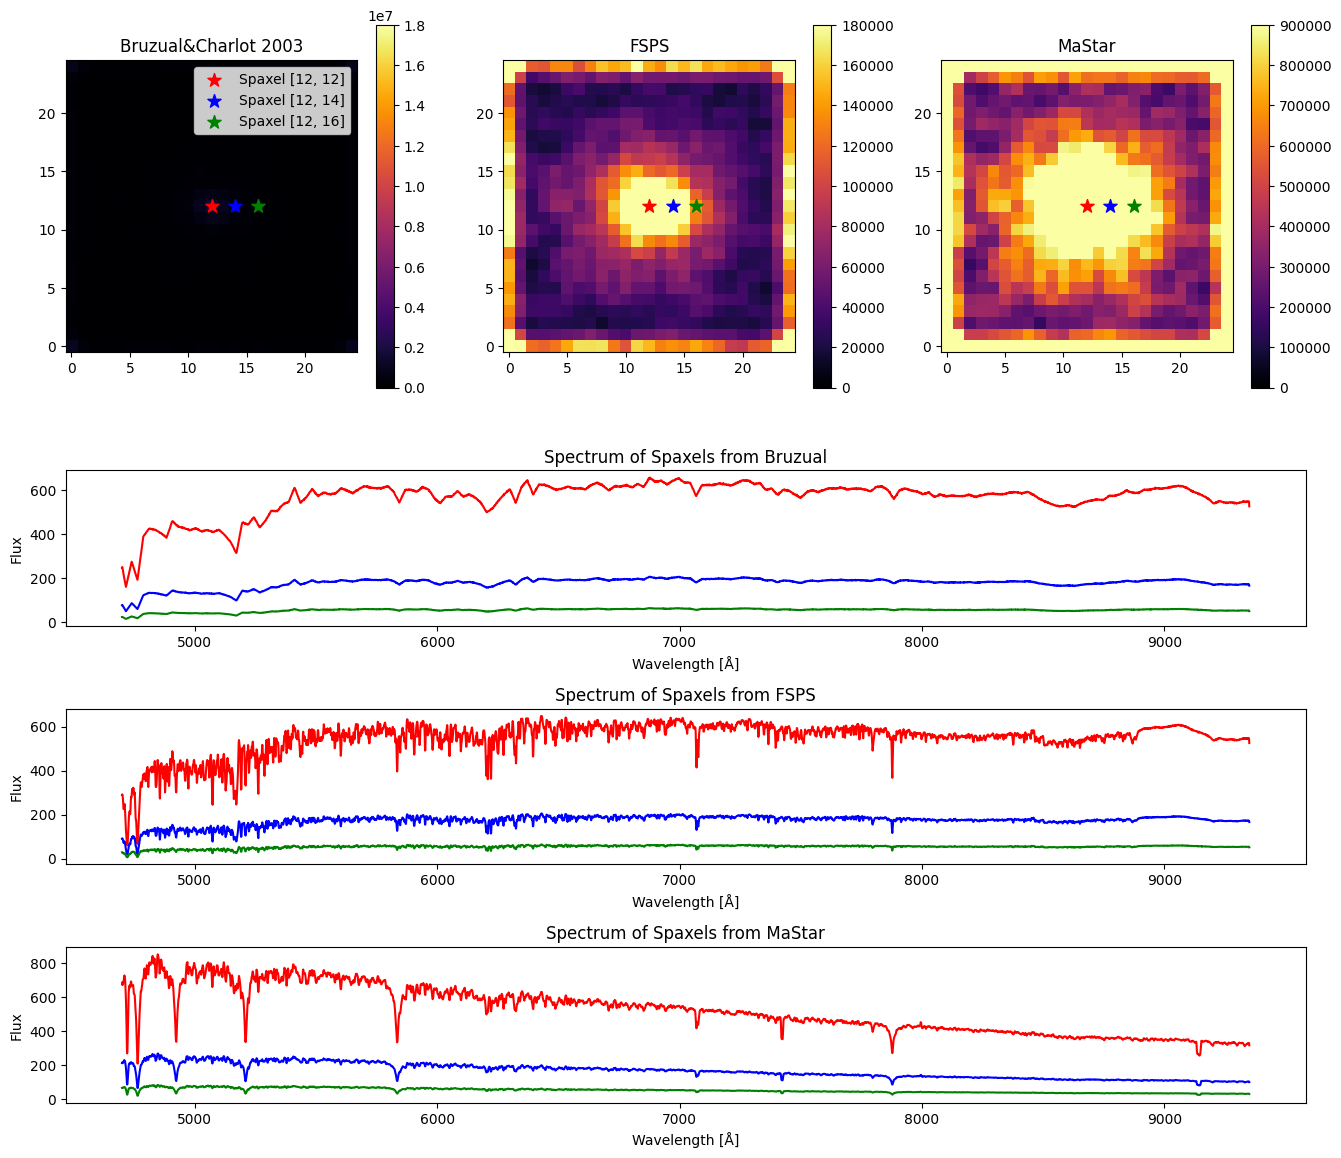

In [11]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

# Assuming wave, spectra, image, image2, and image3 are defined
wave = pipe.telescope.wave_seq
spectra1 = rubixdata_bruzual.stars.datacube
spectra2 = rubixdata_fsps.stars.datacube
spectra3 = rubixdata_mastar.stars.datacube

# Spaxel to highlight
spaxel_x, spaxel_y = 12, 12
spaxel_x2, spaxel_y2 = 12, 14
spaxel_x3, spaxel_y3 = 12, 16

# Example images (replace with your data)
visible_indices = jnp.where((wave >= 4000) & (wave <= 8000))
visible_spectra1 = spectra1[:, :, visible_indices[0]]
visible_spectra2 = spectra2[:, :, visible_indices[0]]
visible_spectra3 = spectra3[:, :, visible_indices[0]]
image1 = jnp.sum(visible_spectra1, axis=2)  # Bruzual image
image2 = jnp.sum(visible_spectra2, axis=2)  # FSPS image
image3 = jnp.sum(visible_spectra3, axis=2)  # MaStar image

vmin = 0

# Create figure with GridSpec
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(4, 3, height_ratios=[0.7, 0.3, 0.3, 0.3], hspace=0.4)

sum1 = jnp.sum(spectra1[spaxel_x, spaxel_y, :])
sum2 = jnp.sum(spectra2[spaxel_x, spaxel_y, :])
sum3 = jnp.sum(spectra3[spaxel_x, spaxel_y, :])
print(sum1, sum2, sum3)

# First row: images
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(image1, origin="lower", cmap="inferno")#, vmin=vmin, vmax=1.8e7)#, norm=LogNorm())
ax1.scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100, label="Spaxel [12, 12]")
ax1.scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100, label="Spaxel [12, 14]")
ax1.scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100, label="Spaxel [12, 16]")
ax1.set_title("Bruzual&Charlot 2003")
ax1.legend()
fig.colorbar(im1, ax=ax1, orientation="vertical")

ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(image2, origin="lower", cmap="inferno")#, vmin=vmin, vmax=1.8e5)#, norm=LogNorm())
ax2.scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100)
ax2.scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100)
ax2.scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100)
ax2.set_title("FSPS")
fig.colorbar(im2, ax=ax2, orientation="vertical")

ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(image3, origin="lower", cmap="inferno")#, vmin=vmin, vmax=0.9e6)#, norm=LogNorm())
ax3.scatter(spaxel_y, spaxel_x, color="red", marker="*", s=100)
ax3.scatter(spaxel_y2, spaxel_x2, color="blue", marker="*", s=100)
ax3.scatter(spaxel_y3, spaxel_x3, color="green", marker="*", s=100)
ax3.set_title("MaStar")
fig.colorbar(im3, ax=ax3, orientation="vertical")

# Second row: spectrum
ax4 = fig.add_subplot(gs[1, :])  # Full-width spectrum
ax4.plot(wave, spectra1[spaxel_x, spaxel_y, :], color="red")
ax4.plot(wave, spectra1[spaxel_x2, spaxel_y2, :], color="blue")
ax4.plot(wave, spectra1[spaxel_x3, spaxel_y3, :], color="green")
#ax4.plot(wave, spectra2[spaxel_x, spaxel_y, :], label=f"Spaxel [{spaxel_x}, {spaxel_y}], FSPS")
#ax4.plot(wave, spectra3[spaxel_x, spaxel_y, :], label=f"Spaxel [{spaxel_x}, {spaxel_y}], MaStar")
ax4.set_title(f"Spectrum of Spaxels from Bruzual")
ax4.set_xlabel("Wavelength [Å]")
ax4.set_ylabel("Flux")
#ax4.set_yscale("log")
#ax4.legend()

ax5 = fig.add_subplot(gs[2, :])  # Full-width spectrum
ax5.plot(wave, spectra2[spaxel_x, spaxel_y, :], color="red")
ax5.plot(wave, spectra2[spaxel_x2, spaxel_y2, :], color="blue")
ax5.plot(wave, spectra2[spaxel_x3, spaxel_y3, :], color="green")
ax5.set_title(f"Spectrum of Spaxels from FSPS")
ax5.set_xlabel("Wavelength [Å]")
ax5.set_ylabel("Flux")
#ax4.set_yscale("log")
#ax5.legend()

ax6 = fig.add_subplot(gs[3, :])  # Full-width spectrum
ax6.plot(wave, spectra3[spaxel_x, spaxel_y, :]/10, color="red")
ax6.plot(wave, spectra3[spaxel_x2, spaxel_y2, :]/10, color="blue")
ax6.plot(wave, spectra3[spaxel_x3, spaxel_y3, :]/10, color="green")
ax6.set_title(f"Spectrum of Spaxels from MaStar")
ax6.set_xlabel("Wavelength [Å]")
ax6.set_ylabel("Flux")
#ax4.set_yscale("log")
#ax6.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()